# Estimating Selection Effects

This notebook accumulates a set of samples in detector-frame masses and distances that are *detected* and corresponding weights (probability density in mass-distance space) that can be used to estimate the selection effects of our hypothetical search.

It turns out that the selection function is the domanant computational cost in most of our analyses, so it is worth minimizing the number of samples we need to properly estimate it.  Here we employ a clever trick.  We look at the distribution of *observed* masses and distances (in log-space, since these quantities must be positive) and use that to construct a distribution of draws for the selection function.  If we knew the distribution of selected systems perfectly, this would be the optimal Monte-Carlo estimate of the selection function.

We cheat a bit for efficiency and use the known, *true* parameters of the detected systems to construct the KDE.  This is not necessary in principle, because we can always choose whatever distributions we like to generate the injections as long as they span the range of likely detected systems.  (But note: if you draw from, say, the likelihood and it is not strongly peaked, as it often is for distance, then you should probably put in a reasonable prior, or you will find a strong systematic offset in the distribution toward small distances that will make it very inefficient.)

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
from bisect import bisect
import h5py
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d, RectBivariateSpline
from scipy.stats import gaussian_kde
import seaborn as sns
from tqdm import tqdm_notebook

sns.set_style('ticks')
sns.set_context('notebook')
sns.set_palette('colorblind')

First, we load and construct and interpolator to give the optimal SNR for masses and distances:

In [3]:
with h5py.File('optimal_snr.h5', 'r') as f:
    ms = array(f['ms'])
    osnrs = array(f['SNR'])
    
rbs = RectBivariateSpline(ms, ms, osnrs)

def optimal_snr(m1, m2, d):
    return rbs.ev(m1, m2)/d

Then we construct an interpolator for the distribution of angular factors:

In [4]:
with h5py.File('thetas.h5', 'r') as f:
    ts = array(f['Theta'])
    
ts = np.append([0, 1], ts)
ts = np.sort(ts)

theta_icdf = interp1d(linspace(0, 1, len(ts)), ts)

Now we look at the observations and construct a KDE that approximates the distribution of observed systems.  We just blindly take the union of the posterior samples (one draw from each event), as this will tend to already be over-dispersed relative to the true population.

In [40]:
with h5py.File('observations.h5', 'r') as f:
    nobs, nsamp = f['posteriors']['m1det'].shape
    
    # Uncomment below to enable truth-based sampling
    m1 = array(f['m1s'])
    m2 = array(f['m2s'])
    zs = array(f['zs'])
    dl = Planck15.luminosity_distance(zs).to(u.Gpc).value
    m1 = m1*(1+zs)
    m2 = m2*(1+zs)

#     # Uncomment below to enable likelihood-based instead of truth-based sampling
#     iobs = arange(nobs, dtype=np.int)
#     isamp = random.choice(nsamp, size=nobs, replace=True)
    
#     m1 = array(f['posteriors']['m1det'])[iobs, isamp]
#     m2 = array(f['posteriors']['m2det'])[iobs, isamp]
#     dl = array(f['posteriors']['dl'])[iobs, isamp]

def to_unconstrained(m1, m2, dl):
    x = log(m1)
    y = log(m2)-log(m1-m2)
    z = log(dl)
    
    return column_stack((x,y,z))

def from_unconstrained(pts):
    x = pts[:,0]
    y = pts[:,1]
    z = pts[:,2]
    
    m1 = exp(x)
    dl = exp(z)
    
    # m2 is tricky to do stably
    m2 = zeros_like(y)

    s = y > 0
    r = exp(-y)
    m2[s] = m1[s]/(1+r[s])
    
    s = y <= 0
    r = exp(y)
    m2[s] = r[s]*m1[s]/(1+r[s])
    
    return column_stack((m1,m2,dl))

def jacobian(m1m2dl, uc):
    m1 = m1m2dl[:,0]
    m2 = m1m2dl[:,1]
    dl = m1m2dl[:,2]
    
    return 1.0/m1 * (1.0/m2 + 1.0/(m1-m2)) * (1.0/dl)

pts = to_unconstrained(m1, m2, dl)
kde = gaussian_kde(pts.T)

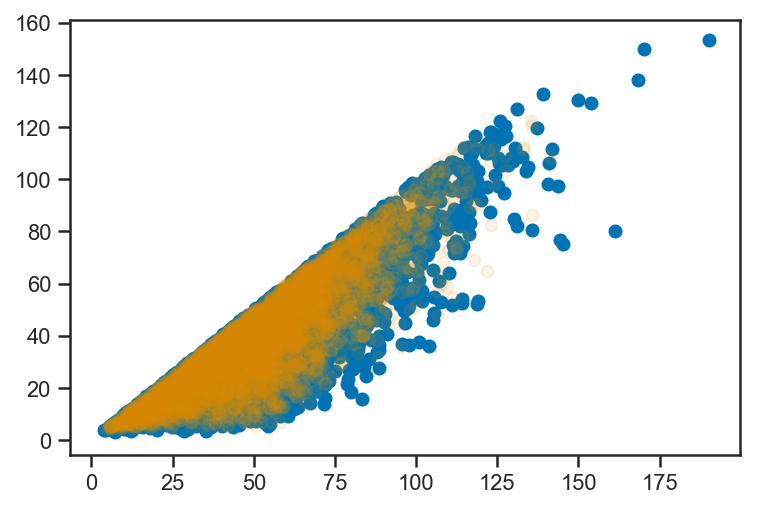

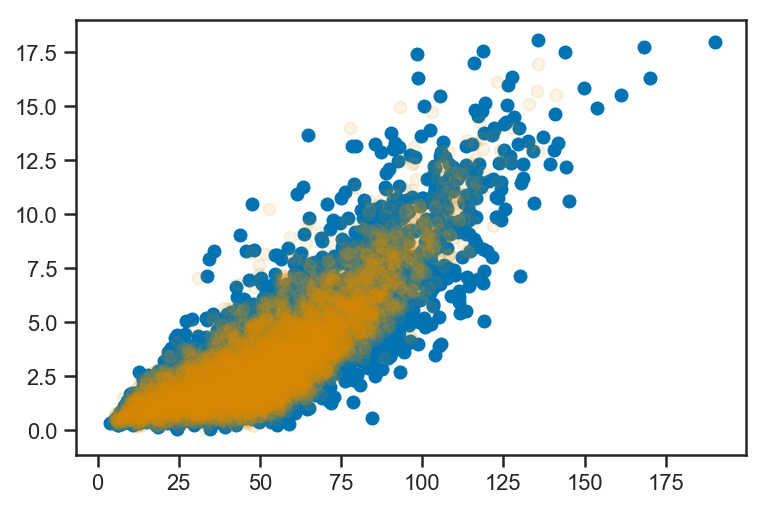

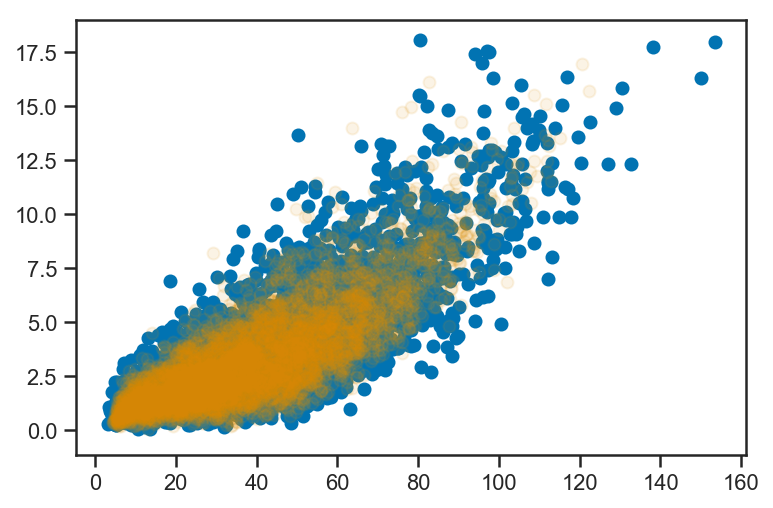

In [41]:
uc = kde.resample(4000).T
m1m2dl = from_unconstrained(uc)

scatter(m1m2dl[:,0], m1m2dl[:,1])
scatter(m1, m2, alpha=0.1)

figure()
scatter(m1m2dl[:,0], m1m2dl[:,2])
scatter(m1, dl, alpha=0.1)

figure()
scatter(m1m2dl[:,1], m1m2dl[:,2])
scatter(m2, dl, alpha=0.1)

Here we draw the SNRs of the masses and distances:

In [42]:
def draw_snrs(m1s, m2s, dls):
    n = len(m1s)
    
    t = theta_icdf(rand(n))
    
    return t*optimal_snr(m1s, m2s, dls) + randn(n)

And here we draw the detected events:

In [43]:
m1s_det = []
m2s_det = []
dls_det = []
wts_det = []

N_gen = 0
chunk_size = 1 << 15
N_desired = 1 << 20

with tqdm_notebook(total=N_desired) as bar:
    while len(m1s_det) == 0 or sum([len(x) for x in m1s_det]) < N_desired:
        uc = kde.resample(chunk_size).T
        m1m2dl = from_unconstrained(uc)
        m1 = m1m2dl[:,0]
        m2 = m1m2dl[:,1]
        dl = m1m2dl[:,2]
        
        # Swap m1 and m2
        s = m2 > m1
        t = m1[s]
        m1[s] = m2[s]
        m2[s] = t
        
        rho = draw_snrs(m1, m2, dl)
        
        N_gen += chunk_size
        
        s = rho > 8
        
        if np.any(s):
            m1s_det.append(m1[s])
            m2s_det.append(m2[s])
            dls_det.append(dl[s])
            
            wts_det.append(kde(uc[s,:].T)*jacobian(m1m2dl[s,:], uc[s,:]))
            
            bar.update(count_nonzero(s))
            
m1s_det = np.concatenate(m1s_det)
m2s_det = np.concatenate(m2s_det)
dls_det = np.concatenate(dls_det)
wts_det = np.concatenate(wts_det)

And here we save them to HDF5:

In [44]:
with h5py.File('selected.h5', 'w') as f:
    f.attrs['N_gen'] = N_gen
    f.create_dataset('m1det', data=m1s_det, compression='gzip', shuffle=True)
    f.create_dataset('m2det', data=m2s_det, compression='gzip', shuffle=True)
    f.create_dataset('dl', data=dls_det, compression='gzip', shuffle=True)
    f.create_dataset('wt', data=wts_det, compression='gzip', shuffle=True)

Execute the below to re-load:

In [45]:
with h5py.File('selected.h5', 'r') as f:
    N_gen = f.attrs['N_gen']
    m1s_det = array(f['m1det'])
    m2s_det = array(f['m2det'])
    dls_det = array(f['dl'])
    wts_det = array(f['wt'])

A quick test, with a distribution that is close to our reference distribution---should come out to be close to 4000 events expected:

In [46]:
z = linspace(0, 3, 1000)
d = Planck15.luminosity_distance(z).to(u.Gpc).value

z_of_d = interp1d(d, z)

def dNdm1dm2ddl(m1det, m2det, dl):
    z = z_of_d(dl)
    
    m1 = m1det/(1+z)
    m2 = m2det/(1+z)
    
    low_cut = where(m2 < 5, 0, 1)
    high_cut = where(m1 > 40, 0, 1)
    
    dVdz = Planck15.differential_comoving_volume(z).to(u.Gpc**3/u.sr).value*4*pi
    dzddl = 1/(dl/(1+z) + (1+z)*Planck15.hubble_distance.to(u.Gpc).value/sqrt((1+z)**3*0.3 + 0.7))
    
    alpha = 0.75
    beta = 0.0
    gamma = 3
    
    MMin = 5
    MMax = 40
    
    m1norm = (1-alpha)/(MMax**(1-alpha) - MMin**(1-alpha))
    m2norm = (beta+1)/(m1**(beta+1) - MMin**(beta+1))
    
    dN = m1norm*m2norm*m1**(-alpha)*m2**beta*(1+z)**(gamma-1)*dVdz*dzddl/(1+z)**2
    
    return low_cut * dN * high_cut

Here we calculate the number of events expected and also the Monte-Carlo uncertainty on that number, and compare to the intrinsic statistical uncertainty, $\sqrt{N}$.

In [47]:
xs = dNdm1dm2ddl(m1s_det, m2s_det, dls_det)/wts_det
s = np.sum(xs)
s2 = np.sum(xs*xs)

v = s2 - s*s/N_gen # var(wt0 + wt1 + ... + wtN + 0 + ... + 0) = N_gen*var([wt0, wt1, ..., wtN, 0, ..., 0])

Nex = 0.5*5*100*s/N_gen
sigma_Nex = sqrt(v)*0.5*5*100/N_gen

Neff = Nex*Nex/(sigma_Nex*sigma_Nex)

Nex, sigma_Nex, Neff

(3633.6728692014917, 11.314052368832947, 103146.68699621306)

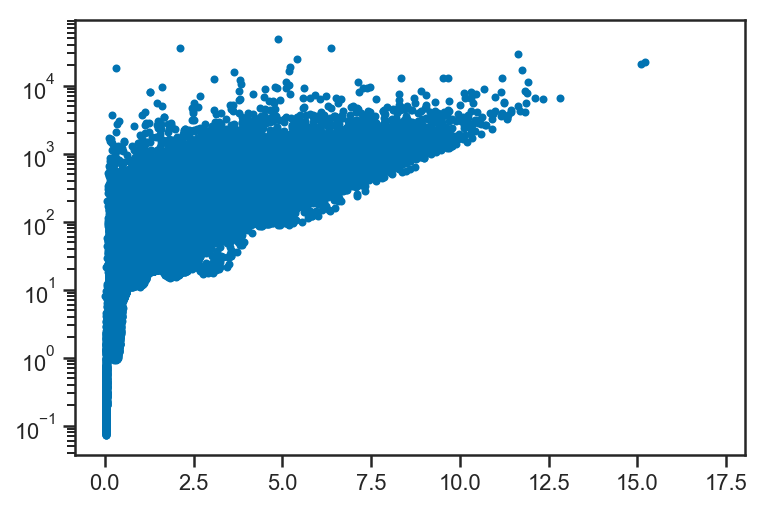

In [48]:
plot(dls_det, xs, '.')
yscale('log')

So, we see that we get one effective sample per $\sim 10$ detected injections:

In [50]:
nperneff = m1s_det.shape[0]/Neff
print('One effective sample per {:.1f} detected injections'.format(nperneff))

One effective sample per 10.2 detected injections


So, if we want to have $N_\mathrm{eff} \sim \mathcal{O}(10) N_\mathrm{obs}$ times, then we will need (rounded to a power of two):

In [51]:
def ceil_pow2(x):
    return 1 << int(ceil(log(x)/log(2)))

with h5py.File('observations.h5', 'r') as f:
    nobs_1yr, _ = f.attrs['1yr']
    nobs_small, _ = f.attrs['small']
    nobs_5yr, _ = f.attrs['5yr']
    
safety_factor = 10

print('nsel for small sample is {:d}'.format(ceil_pow2(safety_factor*nperneff*nobs_small)))
print('nsel for 1yr sample is {:d}'.format(ceil_pow2(safety_factor*nperneff*nobs_1yr)))
print('nsel for 5yr sample is {:d}'.format(ceil_pow2(safety_factor*nperneff*nobs_5yr)))

nsel for small sample is 8192
nsel for 1yr sample is 131072
nsel for 5yr sample is 524288
